<a href="https://colab.research.google.com/github/DiegoPincheiraIb/Experiencias_EL5206/blob/master/Lab_Vinos_Diego.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configuraciones preliminares

In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
import random
from random import randint
from pylab import rcParams
from dateutil.relativedelta import relativedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from tabulate import tabulate
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

# Cargar los Datos

In [2]:
df = pd.read_csv("http://www.forecastingbook.com/mooc/AustralianWines.csv?attredirects=0&d=1")
df.head()

,Month,Fortified,Red,Rose,sparkling,Sweet white,Dry white
0,Jan-80,2585,464,112,1686,85,1954
1,Feb-80,3368,675,118,1591,89,2302
2,Mar-80,3210,703,129,2304,109,3054
3,Apr-80,3111,887,99,1712,95,2414
4,May-80,3756,1139,116,1471,91,2226


Se separa el dataframe en tipos de vinos

In [3]:
fortified = df[['Month','Fortified']]
red = df[['Month','Red ']]
rose = df[['Month','Rose ']]
sparkling = df[['Month','sparkling ']]
sweet_white = df[['Month','Sweet white']]
dry_white = df[['Month','Dry white']]

Se verifica si existen datos nulos

In [4]:
print(fortified.isnull().sum(),
      red.isnull().sum(),
      rose.isnull().sum(),
      sparkling.isnull().sum(),
      sweet_white.isnull().sum(),
      dry_white.isnull().sum()
     )

Month        0
Fortified    0
dtype: int64 Month    0
Red      0
dtype: int64 Month    0
Rose     0
dtype: int64 Month         0
sparkling     0
dtype: int64 Month          0
Sweet white    0
dtype: int64 Month        0
Dry white    0
dtype: int64


Si bien no se presentan datos nulos, se destaca la presencia de dos valores marcados como "*" en "rose". Estos se reemplazarán por un valor aleatorio dentro de la desviación estándar de la media más adelante, utilizando la función Reemplazo_Asteriscos() diseñada en el próximo apartado.

# 2.1: Análisis por tipos de vinos

## Funciones para las predicciones

Se modifica un Dataframe objetivo para que tenga los meses en formato "AAAA-MM-DD". A su vez, se imprime el gráfico de comportamiento, y se descompone el modelo en gráficos que permiten observar su tendencia (Trend), comportamiento estacional (Seasonal), y el ruido presente (Residual).

In [5]:
def Reordenamiento_Meses(DF_Obj, Str_Variable,Plot = True):
  DF_Obj = DF_Obj.groupby('Month')[Str_Variable].sum().reset_index()
  DF_Obj['Month'] = pd.to_datetime(DF_Obj['Month'])
  DF_Obj = DF_Obj.set_index('Month')
  Y_DF_Obj = DF_Obj[Str_Variable].resample('MS').mean()
  if Plot:
    Y_DF_Obj.plot(figsize=(18, 8))
    plt.show()
    rcParams['figure.figsize'] = 18, 8
    Decomposition = sm.tsa.seasonal_decompose(Y_DF_Obj, model='additive')
    fig = Decomposition.plot()
    plt.show()
  return Y_DF_Obj

Esta función, dado una serie objetivo, y un booleano opcional, evalua combinaciones de parámetros del método SARIMA, entregando la combinación que da el valor mínimo de AIC, en conjunto con el valor de este. Mediante el booleano opcional es posible imprimir todas las combinaciones si este es igual a True.

In [6]:
def SARIMA_Param(Y_Obj, Show_All = False):
  Min = ''
  Valor_Min = 9999999999999
  p = d = q = range(0, 2)
  pdq = list(itertools.product(p, d, q))
  seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
  for param in pdq:
      for param_seasonal in seasonal_pdq:
          try:
              mod = sm.tsa.statespace.SARIMAX(Y_Obj,
                                              order=param,
                                              seasonal_order=param_seasonal,
                                              enforce_stationarity=False,
                                              enforce_invertibility=False)
              results = mod.fit()
              if Show_All:
                print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
              if results.aic <= Valor_Min:
                Valor_Min = results.aic
                Min = 'ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic)
          except:
              continue
  print('Minimo: ', Min)

Esta función realiza las predicciones.

In [7]:
def Predicciones_12Meses(Y_Obj, Orden_Obj, Seas_Orden_Obj,Diag = True,Plot_Pred = True):
  mod = sm.tsa.statespace.SARIMAX(Y_Obj,
                                order=Orden_Obj,
                                seasonal_order=Seas_Orden_Obj,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
  results = mod.fit()
  if Diag:
    print(results.summary().tables[1])
    results.plot_diagnostics(figsize=(18, 8))
    plt.show()
  pred = results.get_prediction(start = -24,end = len(Y_Obj) + 11, dynamic=False)
  pred_ci = pred.conf_int()
  if Plot_Pred:
    ax = Y_Obj[:].plot(label='Observed')
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(18, 8))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)
    ax.set_xlabel('Date')
    ax.set_ylabel('Fortified Sales')
    plt.legend()
    plt.show()
  y_forecasted = pred.predicted_mean
  y_truth = Y_Obj[-24:]
  print('La media pronosticada de las ventas para los siguientes 12 meses son los siguientes valores:')
  print(y_forecasted[-12:])
  mse = ((y_forecasted - y_truth) ** 2).mean()
  print('El MSE de las predicciones es {}'.format(round(mse, 2)))
  print('El RMSE de las predicciones es {}'.format(round(np.sqrt(mse), 2)))

In [8]:
def Reemplazo_Asteriscos(DF_Obj, Str_Obj):
  DF_Obj_Copia = DF_Obj.copy()
  DF_Obj_Copia[Str_Obj] = DF_Obj_Copia[Str_Obj].replace('\*', np.nan, regex=True)
  Aux = DF_Obj_Copia[Str_Obj][160:180].dropna().astype(int)
  Media = Aux.mean()
  STD = Aux.std()
  Value = Media + (randint(-int(STD),int(STD)))
  DF_Obj_Copia[Str_Obj] = DF_Obj_Copia[Str_Obj].replace(np.nan, Value, regex=True).astype(int)
  return DF_Obj_Copia

## Fortified

In [9]:
y_fortified = Reordenamiento_Meses(fortified, 'Fortified', False)
SARIMA_Param(y_fortified)

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Minimo:  ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:2169.0164995610994


Los resultados anteriores indican que los parámetros más cercanos al modelo consisten en ARIMA(0, 1, 1)x(1, 1, 1, 12)12, con AIC:2169.0164995610994.

In [10]:
Predicciones_12Meses(y_fortified, (0,1,1), (1,1,1,12),Diag = False, Plot_Pred = False)


La media pronosticada de las ventas para los siguientes 12 meses son los siguientes valores:
1995-01-01    1025.272339
1995-02-01    1338.145003
1995-03-01    1812.498338
1995-04-01    2235.931332
1995-05-01    2257.345805
1995-06-01    2458.032145
1995-07-01    2730.501748
1995-08-01    2281.788569
1995-09-01    2102.694126
1995-10-01    1784.691603
1995-11-01    2464.387132
1995-12-01    2425.162183
Freq: MS, dtype: float64
El MSE de las predicciones es 61567.01
El RMSE de las predicciones es 248.13


## Red

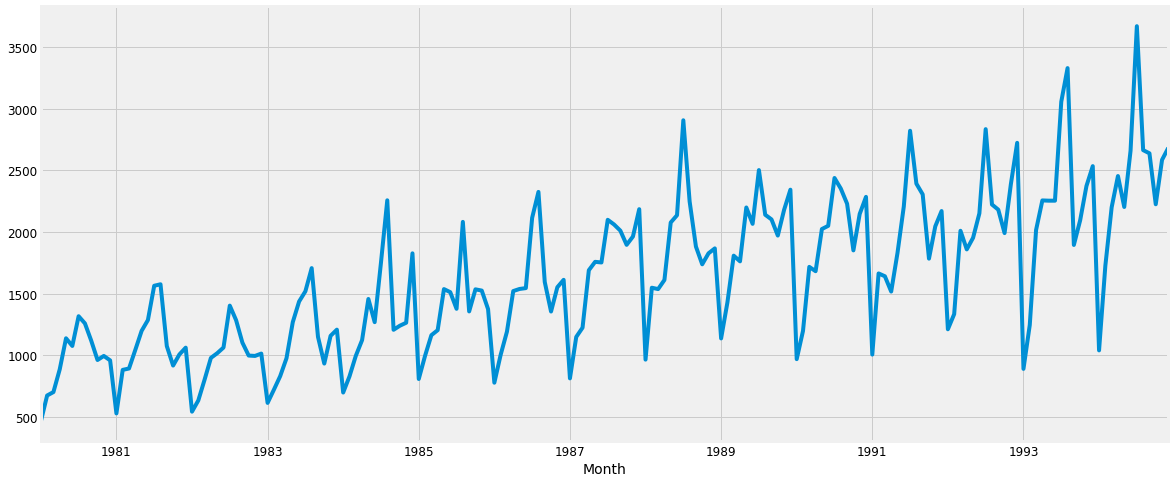

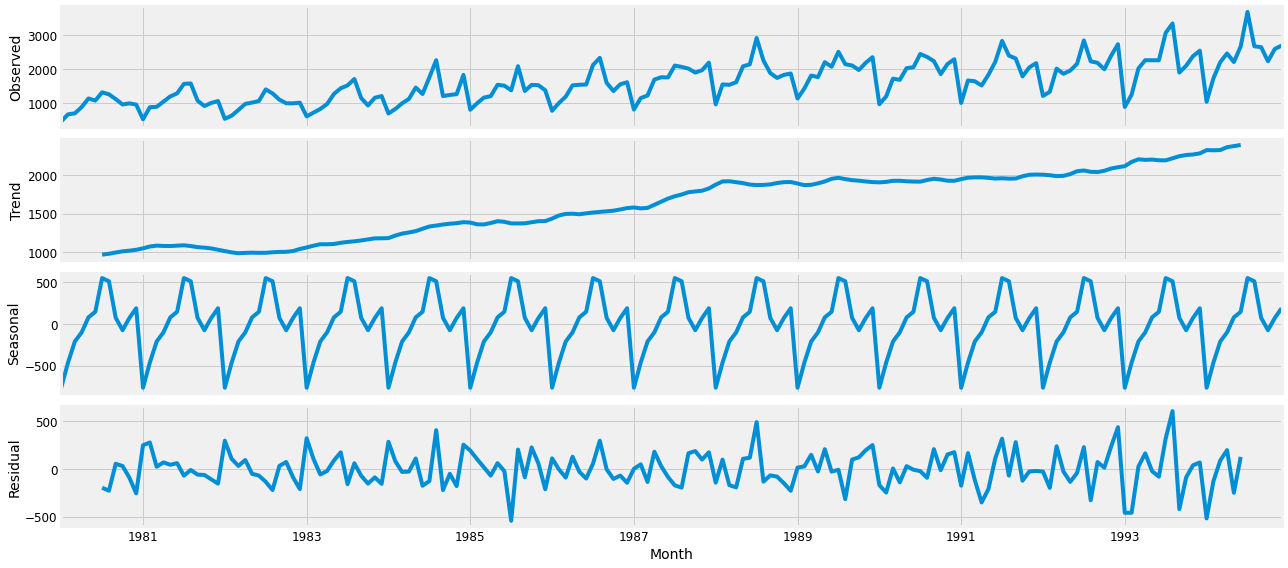

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Minimo:  ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:2086.391382650295


In [11]:
y_red = Reordenamiento_Meses(red, 'Red ')
SARIMA_Param(y_red)

In [12]:
Predicciones_12Meses(y_red, (0,1,1), (0,1,1,12),Diag = False, Plot_Pred = False)


La media pronosticada de las ventas para los siguientes 12 meses son los siguientes valores:
1995-01-01    1366.257040
1995-02-01    1823.064709
1995-03-01    2316.000299
1995-04-01    2437.484569
1995-05-01    2450.595608
1995-06-01    2673.663634
1995-07-01    3448.596986
1995-08-01    2998.255484
1995-09-01    2606.713782
1995-10-01    2392.001663
1995-11-01    2699.084607
1995-12-01    2854.130957
Freq: MS, dtype: float64
El MSE de las predicciones es 95623.4
El RMSE de las predicciones es 309.23


## Rose

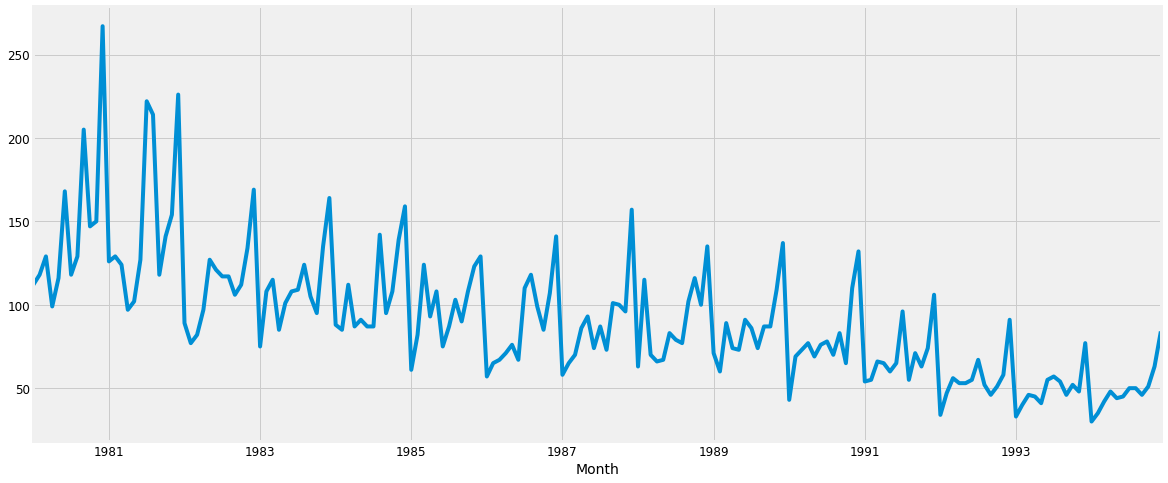

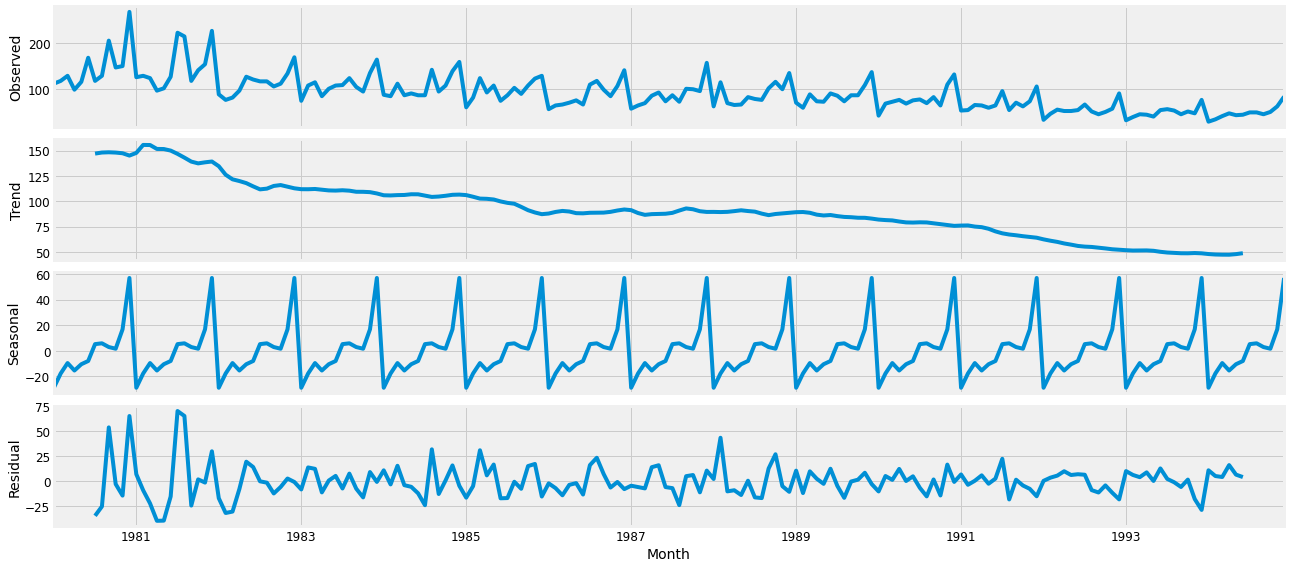

Minimo:  ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:1287.0074003948812


In [13]:
rose = Reemplazo_Asteriscos(rose, 'Rose ') # Se reemplazan asteriscos
y_rose = Reordenamiento_Meses(rose, 'Rose ')
SARIMA_Param(y_rose)

In [14]:
Predicciones_12Meses(y_rose, (1,1,1), (0,1,1,12),Diag = False, Plot_Pred = False)

La media pronosticada de las ventas para los siguientes 12 meses son los siguientes valores:
1995-01-01    21.936373
1995-02-01    29.424260
1995-03-01    36.457162
1995-04-01    37.808765
1995-05-01    34.588215
1995-06-01    39.907879
1995-07-01    47.114385
1995-08-01    40.102057
1995-09-01    38.459782
1995-10-01    41.321122
1995-11-01    50.093668
1995-12-01    76.688995
Freq: MS, dtype: float64
El MSE de las predicciones es 58.29
El RMSE de las predicciones es 7.63


## Sparkling

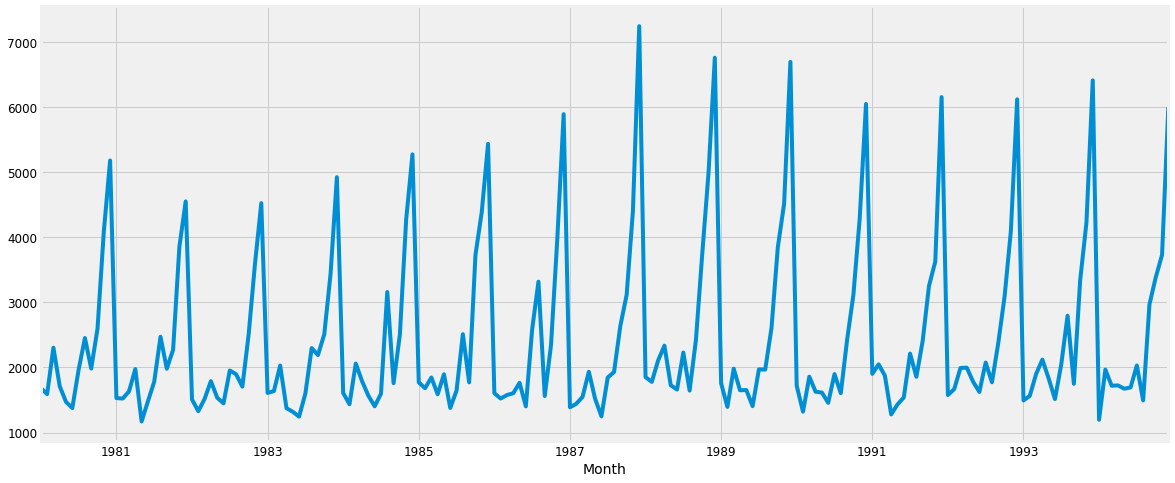

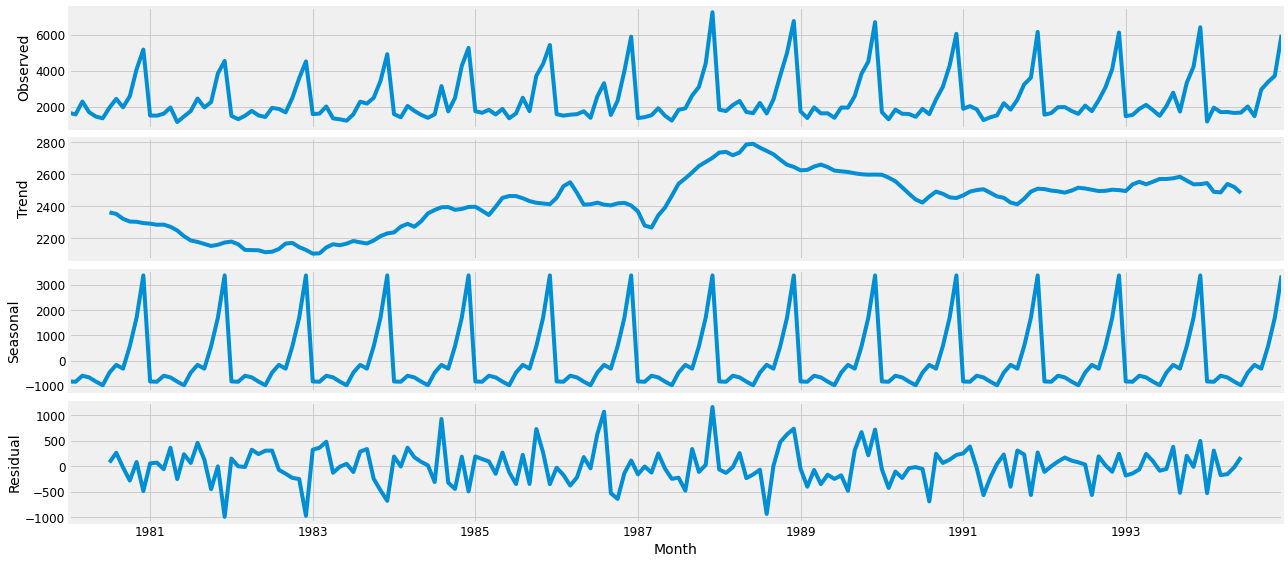

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Minimo:  ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:2271.5217326848706


In [15]:
y_sparkling = Reordenamiento_Meses(sparkling, 'sparkling ')
SARIMA_Param(y_sparkling)

In [16]:
Predicciones_12Meses(y_sparkling,(0, 1, 1),(0, 1, 1, 12),Diag = False, Plot_Pred = False)

La media pronosticada de las ventas para los siguientes 12 meses son los siguientes valores:
1995-01-01    1415.592331
1995-02-01    1746.038746
1995-03-01    1808.169608
1995-04-01    1800.624848
1995-05-01    1677.485084
1995-06-01    1572.620076
1995-07-01    2024.222047
1995-08-01    1898.463232
1995-09-01    2449.545190
1995-10-01    3288.779902
1995-11-01    3948.614024
1995-12-01    6141.863565
Freq: MS, dtype: float64
El MSE de las predicciones es 159111.01
El RMSE de las predicciones es 398.89


## Sweet white

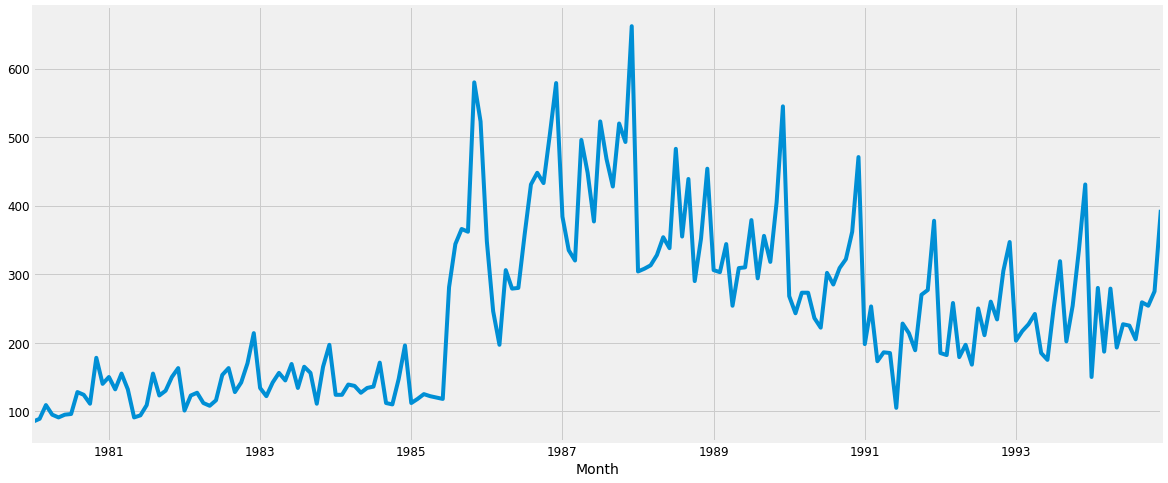

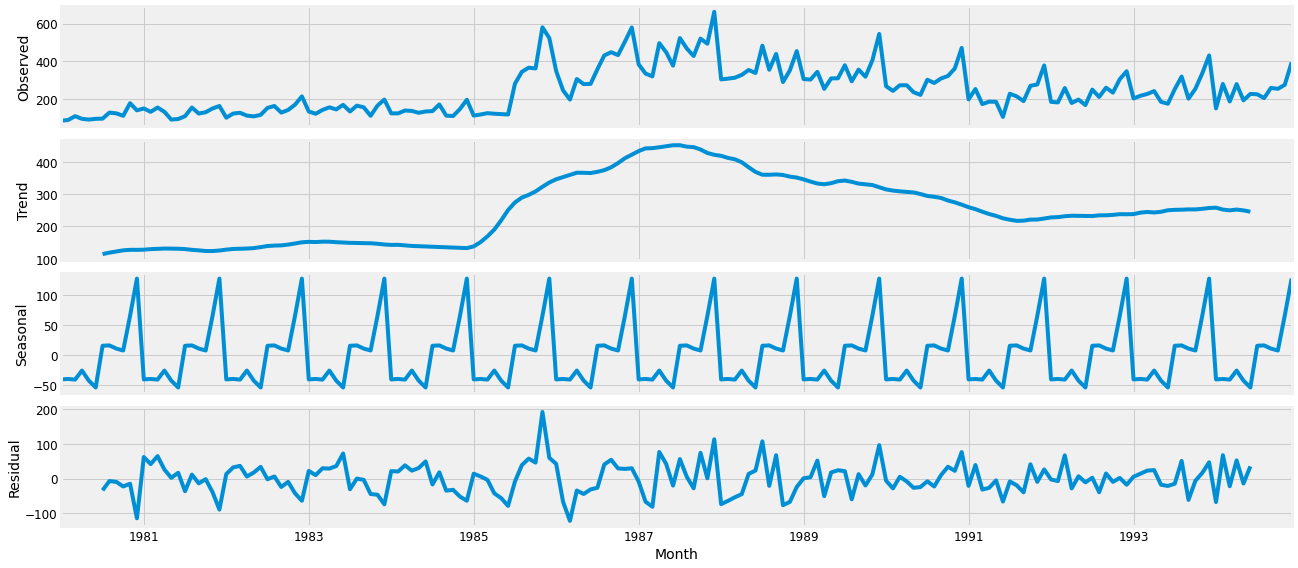

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Minimo:  ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:1671.9867567083738


In [17]:
y_sweet_white = Reordenamiento_Meses(sweet_white, 'Sweet white')
SARIMA_Param(y_sweet_white)

In [18]:
Predicciones_12Meses(y_sweet_white,(1, 1, 1),(1, 1, 1, 12),Diag = False, Plot_Pred = False)

La media pronosticada de las ventas para los siguientes 12 meses son los siguientes valores:
1995-01-01    168.938280
1995-02-01    208.997439
1995-03-01    182.837172
1995-04-01    218.873041
1995-05-01    184.907054
1995-06-01    185.714237
1995-07-01    238.427677
1995-08-01    231.437294
1995-09-01    244.625934
1995-10-01    242.034631
1995-11-01    288.929113
1995-12-01    374.558187
Freq: MS, dtype: float64
El MSE de las predicciones es 2450.14
El RMSE de las predicciones es 49.5


## Dry white

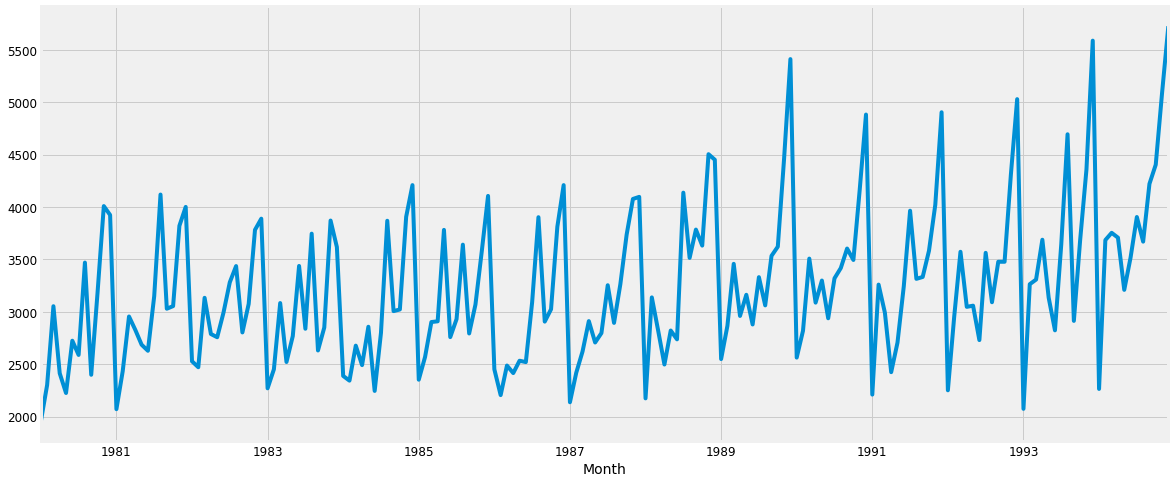

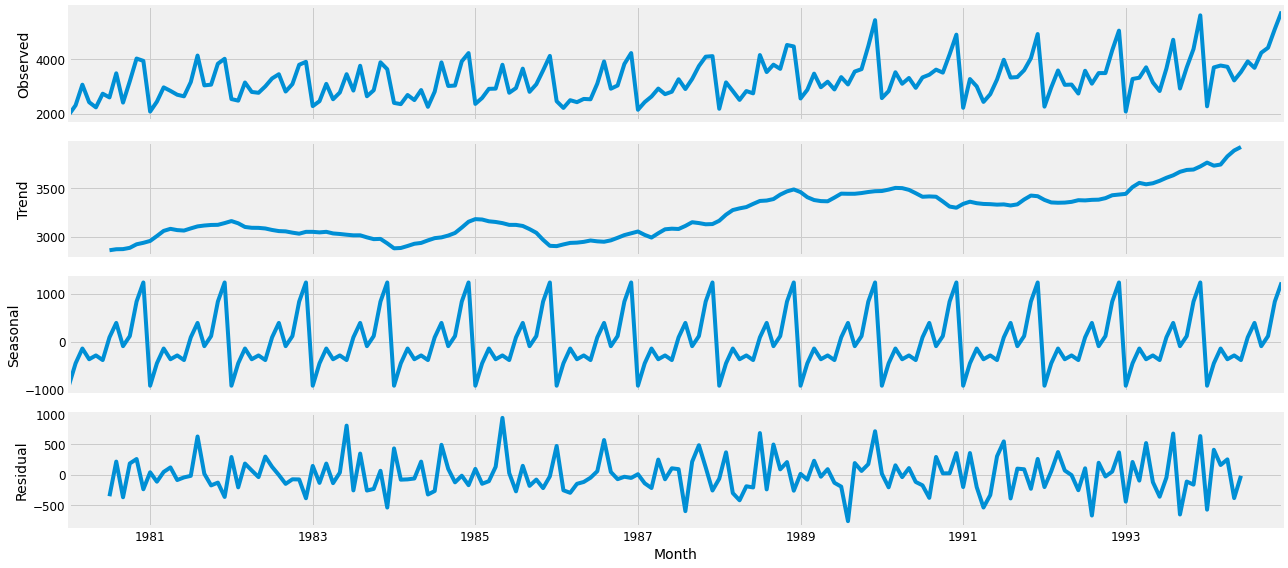

Minimo:  ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:2233.242568479068


In [19]:
y_dry_white = Reordenamiento_Meses(dry_white, 'Dry white')
SARIMA_Param(y_dry_white)

In [20]:
Predicciones_12Meses(y_dry_white,(0, 1, 1),(0, 1, 1, 12),Diag = False, Plot_Pred = False)

La media pronosticada de las ventas para los siguientes 12 meses son los siguientes valores:
1995-01-01    2772.408454
1995-02-01    3775.500079
1995-03-01    3956.855210
1995-04-01    3830.026039
1995-05-01    3615.157252
1995-06-01    3605.689673
1995-07-01    4218.307963
1995-08-01    4239.568927
1995-09-01    4097.769149
1995-10-01    4362.448996
1995-11-01    5048.002660
1995-12-01    5824.616165
Freq: MS, dtype: float64
El MSE de las predicciones es 207799.62
El RMSE de las predicciones es 455.85


# 2.2 - 2.8: Desempeño de pronosticos dado conjuntos de entrenamiento y validación

## Funciones:

Esta función recibe un dataframe objetivo, un par de SARIMA orden y season, y la cantidad de años del final de la serie de tiempo que se desea asignar al conjunto de validacion, y entrega un conjunto de entrenamiento, un conjunto de validación, y un modelo SARIMA entrenado con el conjunto de entrenamiento.

In [28]:
def Cjts_Training_Val_Modelo(Y_Obj, Orden_Obj, Seas_Orden_Obj,Year_Obj, Plot=False):
  Training_Set = Y_Obj[:-12*Year_Obj]
  Val_Set = Y_Obj[-12*Year_Obj:]
  Modelo_Obj = sm.tsa.statespace.SARIMAX(Training_Set,
                                order=Orden_Obj,
                                seasonal_order=Seas_Orden_Obj,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
  Modelo_Entrenado = Modelo_Obj.fit()
  return Training_Set, Val_Set, Modelo_Entrenado

Esta función recibe un conjunto objetivo y un modelo, retornando la predicción del conjunto y el intervalo de confianza al 80%, y ploteando la comparación de los datos y su predicción. Es posible predecir **meses adicionales** añadiendo un valor "Meses_Pred" mayor a 0.

In [ ]:
def Realizar_Predicc_Cjto_Obj(Cjto_Obj, Modelo_Obj,Meses_Pred = 0, Plot = False):
  End_Year = len(Cjto_Obj)
  Predicc_Cjto = Modelo_Obj.get_prediction(start = Cjto_Obj.index[0],end = Cjto_Obj.index[-1]+ relativedelta(months=+Meses_Pred),dynamic=False)
  Predicc_Cjto_ci = Predicc_Cjto.conf_int(alpha=0.2)
  if Plot:
    ax = Cjto_Obj[:].plot(label='Observed')
    Predicc_Cjto.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(18, 8))
    ax.fill_between(Predicc_Cjto_ci.index,
                    Predicc_Cjto_ci.iloc[:, 0],
                    Predicc_Cjto_ci.iloc[:, 1], color='k', alpha=.2)
    ax.set_xlabel('Date')
    ax.set_ylabel('Sales')
    plt.legend()
    plt.show()
  return Predicc_Cjto, Predicc_Cjto_ci

Esta función entrega la performance de los datos originales y los datos predecidos.

In [ ]:
def summary_performance(expected,predictions):
  forecast_errors = [expected[i]-predictions[i] for i in range(len(expected))]
  bias = sum(forecast_errors)*1.0/len(expected)
  mae = mean_absolute_error(expected, predictions)
  mse = mean_squared_error(expected, predictions)
  rmse = sqrt(mse)
  print(tabulate([['Bias:',bias], ['MAE:',mae], ['MSE:',mse], ['RMSE:',rmse]], headers=['Measure', 'Num'], tablefmt='orgtbl'))

Dado un conjunto y sus predicciones, grafica los residuos.

In [ ]:
def Ploteo_Residuos(expected, prediction, wine_name, conjunto_name, Meses_Obj = 12):
  Residuos = expected - prediction.predicted_mean[:-Meses_Obj]
  plt.figure(figsize=(18, 8))
  plt.plot(Residuos)
  plt.ylabel('Residuals')
  plt.xlabel('Month')
  plt.title('Error in Naive Forecast \n on the  '+conjunto_name+' set for '+wine_name+' Wines')
  plt.show()
  return Residuos

Dado residuos, calcula su histograma.

In [ ]:
def histograma(Elem_Obj, wine_name, conjunto_name):
  H, B = np.histogram(Elem_Obj, bins = 10)
  width = 0.7 * (B[1] - B[0])
  center = (B[:-1] + B[1:]) / 2
  plt.figure(figsize=(18, 8))
  plt.bar(center, H, align='center', width=width)
  plt.title('Histogram of Residuals of Forecast on the  '+conjunto_name+' set for '+wine_name+' Wines')
  plt.ylabel('Frequency')
  plt.xlabel('Residuos')
  plt.show()

## Aplicacion

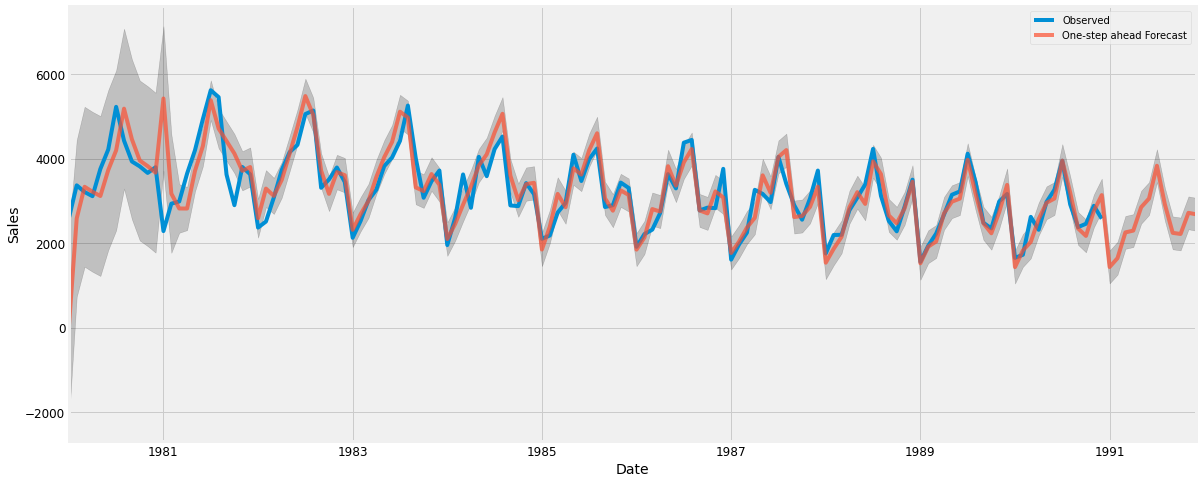

| Measure   |        Num |
|-----------+------------|
| Bias:     |    -12.645 |
| MAE:      |    326.396 |
| MSE:      | 262909     |
| RMSE:     |    512.746 |


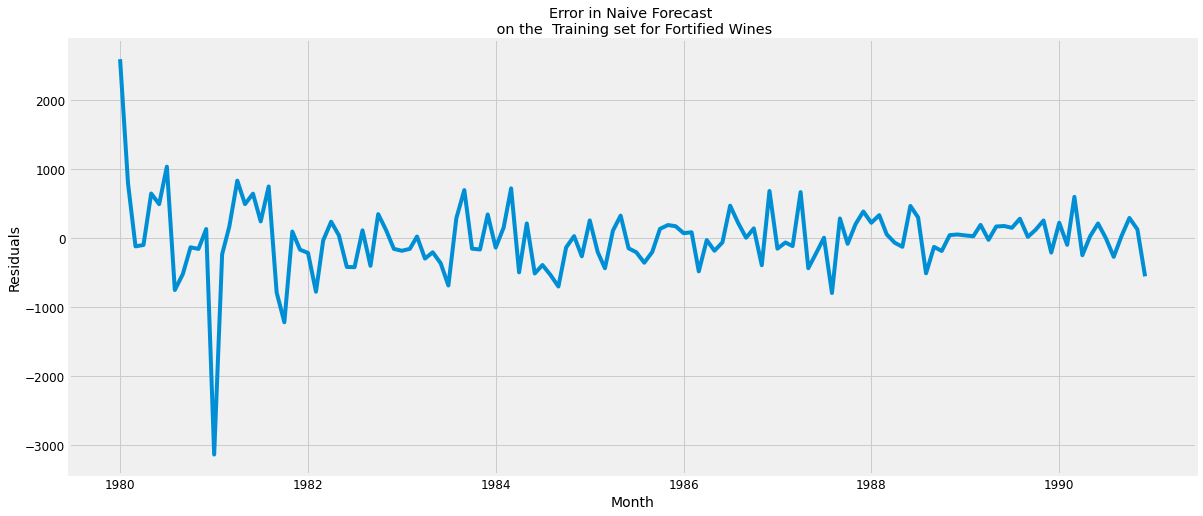

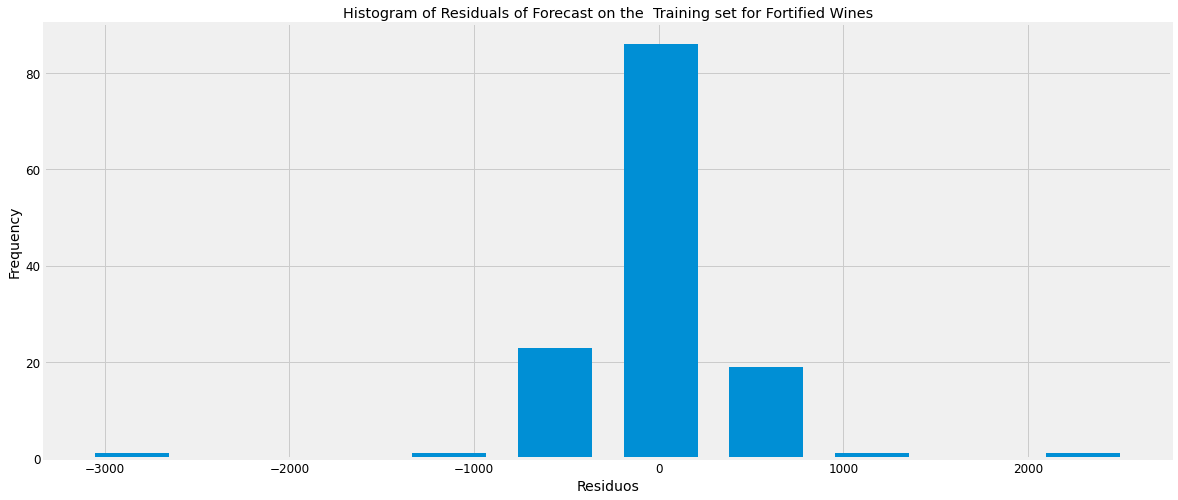

In [31]:
# Se crean los conjuntos de entrenamiento y validación
Training_Fortified, Val_Fortified, Modelo_Fortified = Cjts_Training_Val_Modelo(y_fortified, (0,1,1), (1,1,1,12), 4)
# Se realiza una predicción del conjunto de Entrenamiento
Train_Pred_Fortified, Train_Pred_Fortified_ci = Realizar_Predicc_Cjto_Obj(Training_Fortified,Modelo_Fortified, Plot=True,Meses_Pred = 12)
# Se evalua el desempeño del conjunto de entrenamiento
summary_performance(Training_Fortified,Train_Pred_Fortified.predicted_mean[:-12])
# Se ven los residuos
Residuos_Fortified = Ploteo_Residuos(Training_Fortified,Train_Pred_Fortified,'Fortified', 'Training')
# Se grafica un histograma de los residuos
histograma(Residuos_Fortified,'Fortified', 'Training')

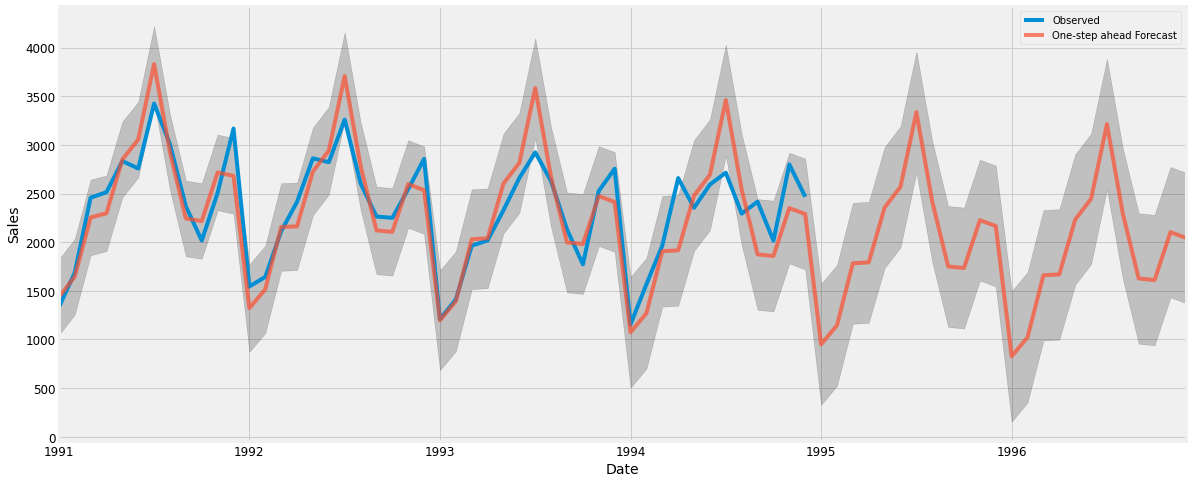

| Measure   |        Num |
|-----------+------------|
| Bias:     |    17.4948 |
| MAE:      |   214.412  |
| MSE:      | 79446.1    |
| RMSE:     |   281.862  |


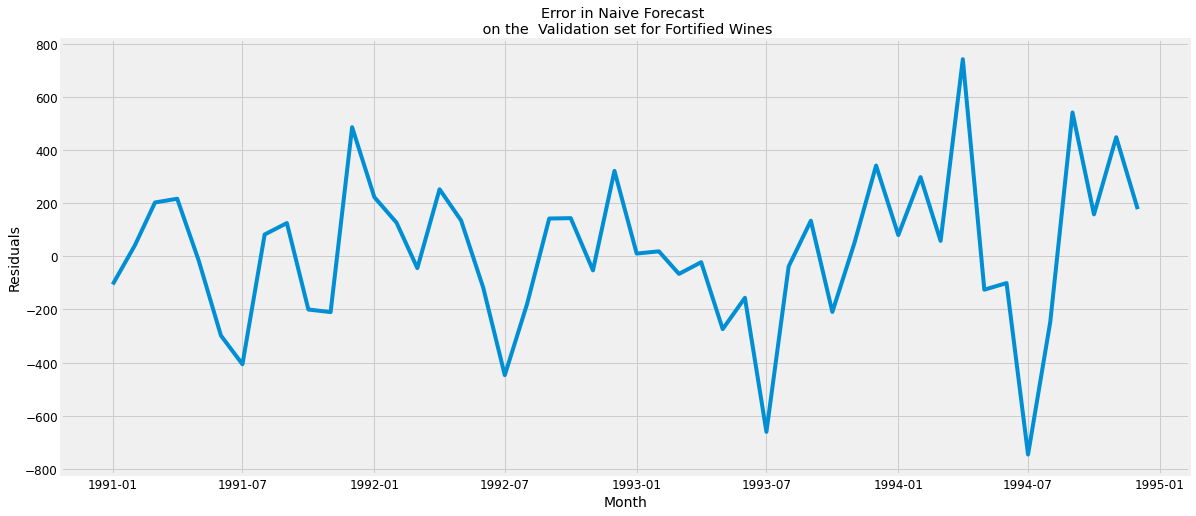

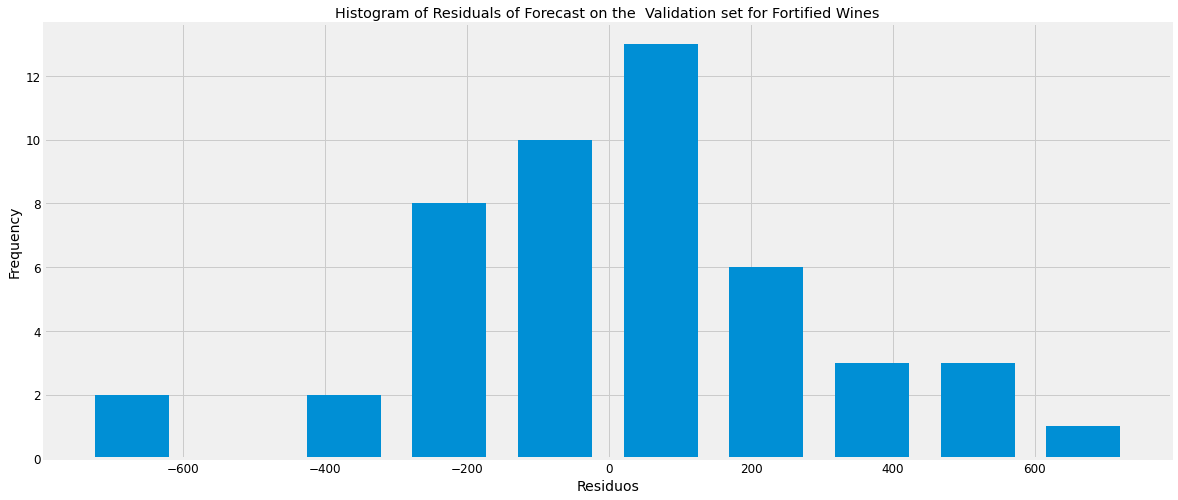

In [35]:
# Se realiza una predicción del conjunto de Entrenamiento
Meses_A_Pred = 24
Val_Pred_Fortified, Val_Pred_Fortified_ci = Realizar_Predicc_Cjto_Obj(Val_Fortified,Modelo_Fortified, Plot=True,Meses_Pred = Meses_A_Pred)
# Se evalua el desempeño del conjunto de validación
summary_performance(Val_Fortified,Val_Pred_Fortified.predicted_mean[:-1*Meses_A_Pred])
# Se ven los residuos
Residuos_Fortified = Ploteo_Residuos(Val_Fortified,Val_Pred_Fortified,'Fortified', 'Validation', Meses_A_Pred)
# Se grafica un histograma de los residuos
histograma(Residuos_Fortified,'Fortified', 'Validation')

# Ejemplo

In [25]:
df = pd.read_excel("C:/Users/ascan/Downloads/Superstore.xls")
furniture = df.loc[df['Category'] == 'Furniture']

FileNotFoundError: ignored

In [ ]:
furniture['Order Date'].min(), furniture['Order Date'].max()

In [ ]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')
furniture.isnull().sum()

In [ ]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

In [ ]:
furniture = furniture.set_index('Order Date')
furniture.index

In [ ]:
y = furniture['Sales'].resample('MS').mean()

In [ ]:
y['2017':]

In [ ]:
y.plot(figsize=(15, 6))
plt.show()

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [ ]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

In [ ]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

In [ ]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [ ]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

In [ ]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

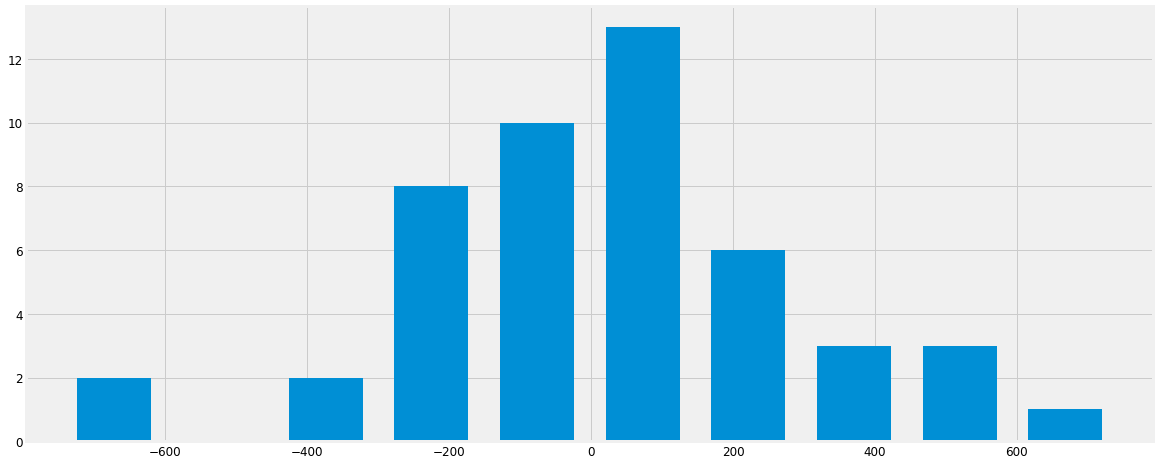

In [ ]:
DataF = Val_Fortified - Val_Pred_Fortified.predicted_mean[:-12]
H, B = np.histogram(DataF, bins = 10)
#print(H, B)
#print(DataF.hist(bins=10)) # La diferencia entre lo predicho y lo obtenido
width = 0.7 * (B[1] - B[0])
center = (B[:-1] + B[1:]) / 2
plt.bar(center, H, align='center', width=width)
plt.show()

# Obsoleto

In [ ]:
### NO OCUPAR!

def Cjts_Training_Val(Y_Obj, Orden_Obj, Seas_Orden_Obj,Year_Obj, Plot=False):
  Training_Set = Y_Obj[:-12*Year_Obj]
  Val_Set = Y_Obj[-12*Year_Obj:]
  mod = sm.tsa.statespace.SARIMAX(Y_Obj,
                                order=Orden_Obj,
                                seasonal_order=Seas_Orden_Obj,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
  results = mod.fit()
  Traininig_Pred = results.get_prediction(end = -12*Year_Obj, dynamic=False)
  Val_Pred = results.get_prediction(start = -12*Year_Obj,end = len(Y_Obj) + 11, dynamic=False)
  Val_Pred_ci = Val_Pred.conf_int(alpha=0.2)
  if Plot:
    ax = Y_Obj['1984':].plot(label='Observed')
    Val_Pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(18, 8))
    ax.fill_between(Val_Pred_ci.index,
                    Val_Pred_ci.iloc[:, 0],
                    Val_Pred_ci.iloc[:, 1], color='k', alpha=.2)
    ax.set_xlabel('Date')
    ax.set_ylabel('Fortified Sales')
    plt.legend()
    plt.show()
    y_forecasted = Val_Pred.predicted_mean
    y_truth = Y_Obj['1994-11-01':]
    mse = ((y_forecasted - y_truth) ** 2).mean()
    print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
    print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))
  return Traininig_Pred,Training_Set, Val_Pred, Val_Set, Val_Pred_ci